<a href="https://colab.research.google.com/github/pbenito1/TFM/blob/main/MachineLearning_FeaturesLexicas.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Imports
import re
import os
from collections import Counter
import pandas as pd
from math import log
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.colors import ListedColormap
import sklearn
from sklearn import ensemble
from sklearn import feature_extraction
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, accuracy_score, recall_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import cross_val_score,train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler

# Clasificadores

from sklearn import svm
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, RandomForestRegressor
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor, export_graphviz
from sklearn import tree

'''
from sklearn.tree import DecisionTreeClassifier
from sklearn import metrics
'''
import graphviz 

%matplotlib inline

In [2]:
# Estilos seaborn
sns.set(rc={"figure.dpi":150, 'savefig.dpi':150})
sns.set_context('notebook')
sns.set_style("ticks")

from IPython.display import set_matplotlib_formats
set_matplotlib_formats('png')

In [3]:
def custom_cm(cf_matrix):
  # Ref: https://medium.com/@dtuk81/confusion-matrix-visualization-fc31e3f30fea
  group_names = ['TN','FP','FN','TP']
  group_counts = ["{0:0.0f}".format(value) for value in cf_matrix.flatten()]
  group_percentages = ["{0:.2%}".format(value) for value in cf_matrix.flatten()/np.sum(cf_matrix)]
  labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in zip(group_names,group_counts,group_percentages)]
  labels = np.asarray(labels).reshape(2,2)
  sns.heatmap(cf_matrix, annot=labels, fmt='', cmap='Blues')

In [4]:
# Cargamos datos
DATASET_PATH='/content/drive/MyDrive/TFM/data_processed/dga.csv'
df = pd.read_csv(DATASET_PATH,index_col=0)

In [5]:
df.sample(10)

,domain,family,category,tld,sld,subdomains_number,digits,length,num_dashes,entropy,ratio_vc,3gram,4gram,5gram,6gram
672121,politros.com,benign,benign,com,politros,2,0,8,0,2.750000,0.600000,6,5,4,3
730692,underthelaces.com,benign,benign,com,underthelaces,2,0,13,0,3.334679,0.625000,11,10,9,8
62937,d2ebf43086adac7b3c9f4573d958b6f7d6.so,dyre,malign,so,d2ebf43086adac7b3c9f4573d958b6f7d6,2,19,34,0,3.799979,0.096774,27,6,0,0
337119,qkwwmwmmgeeccwea.org,ramdo,malign,org,qkwwmwmmgeeccwea,2,0,16,0,2.780639,0.333333,14,5,0,0
3775,1ddb80dba9d96c26a8d2d78831b39358.cz.cc,bamital,malign,cc,cz,3,0,2,0,1.000000,0.000000,0,0,0,0
918257,gobiernoenlinea.gov.co,benign,benign,gov.co,gobiernoenlinea,3,0,15,0,3.006239,1.142857,13,12,11,10
918133,nykdaily.com,benign,benign,com,nykdaily,2,0,8,0,2.750000,0.333333,6,5,4,3
249575,piwhepgrwedzpgez.ru,sutra,malign,ru,piwhepgrwedzpgez,2,0,16,0,3.030639,0.333333,14,9,3,0
377422,nopowam.info,simda,malign,info,nopowam,2,0,7,0,2.521641,0.750000,5,4,0,0
94630,bea325c2.top,infy,malign,top,bea325c2,2,4,8,0,2.750000,0.333333,5,1,0,0


In [ ]:
# Aplicamos *one-hot encoding* a la variable TLD
# df = pd.concat([df, pd.get_dummies(df['tld'])], axis=1)

# WARN: Aunque es posible aplicar one-hot encoding, luego no es posible 
# aplicar algoritmos de machine learning porque da fallo de memoria

Eliminamos las variables tipo texto, categóricas y los n-gramas

In [6]:
y = df['category']
X = df.drop(['family','category','domain','tld','sld','3gram','4gram','5gram','6gram',], axis=1)

Aplicamos a las variables restantes un escalado estandar, en el cual a cada columna se le resta la media de esa columna y se le divide por su desviación típica. Utilizamos para ello la función `StandarScaler` de la librería `sklearn`:

In [7]:
X_std_scaler = StandardScaler().fit_transform(X)
X_std = pd.DataFrame(X_std_scaler, index=X.index, columns=X.columns)

Realizamos un muestreo estratificado en función de la familia.

In [8]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=df['family'])
X_train_std, X_test_std, y_train_std, y_test_std = train_test_split(X, y, test_size=0.2, random_state=42, stratify=df['family'])

#Regresión logística

En primer lugar vamos a entrenar un clasificador clásico basado en regresión logística. Para el entrenamiento utilizaremos los datos previamente estandarizados.

In [16]:
log_clf = LogisticRegression(solver="lbfgs", random_state=42)
log_clf.fit(X_train_std, y_train_std)
y_pred_log = log_clf.predict(X_test_std)

In [17]:
print("El accuracy del clasificador LogisticRegression es:", log_clf.score(X_test_std, y_test_std))

El accuracy del clasificador LogisticRegression es: 0.7593213366709262


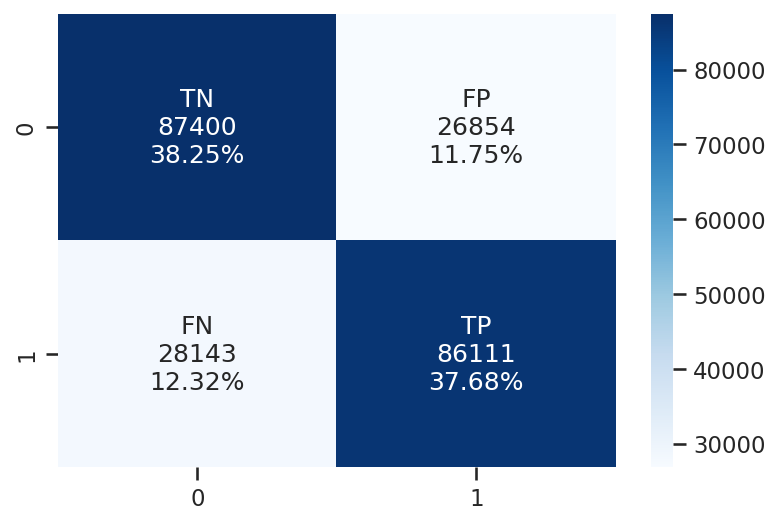

In [18]:
cf_matrix = confusion_matrix(y_test_std, y_pred_log)
custom_cm(cf_matrix)

In [19]:
print(classification_report(y_test_std, y_pred_log))

              precision    recall  f1-score   support

      benign       0.76      0.76      0.76    114254
      malign       0.76      0.75      0.76    114254

    accuracy                           0.76    228508
   macro avg       0.76      0.76      0.76    228508
weighted avg       0.76      0.76      0.76    228508



# Árbol de decision

Uno de los clasificadores más comunes y estudiados son los árboles de decisión. La ventaja que aporta este tipo de modelos no está relacionada con su capacidad de predicción, sino con su capacidad explicativa y la facilidad con la que se puede interpretar el modelo obtenido.

In [9]:
# Instanciamos DecisionTreeClassifier de sklearn
dt_cls = DecisionTreeClassifier(max_depth = 3,  # Máxima profundidad del árbol
                             random_state = 42) # Semilla pseudoaleatorios
# Entrenamos el modelo
dt_cls.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=3, random_state=42)

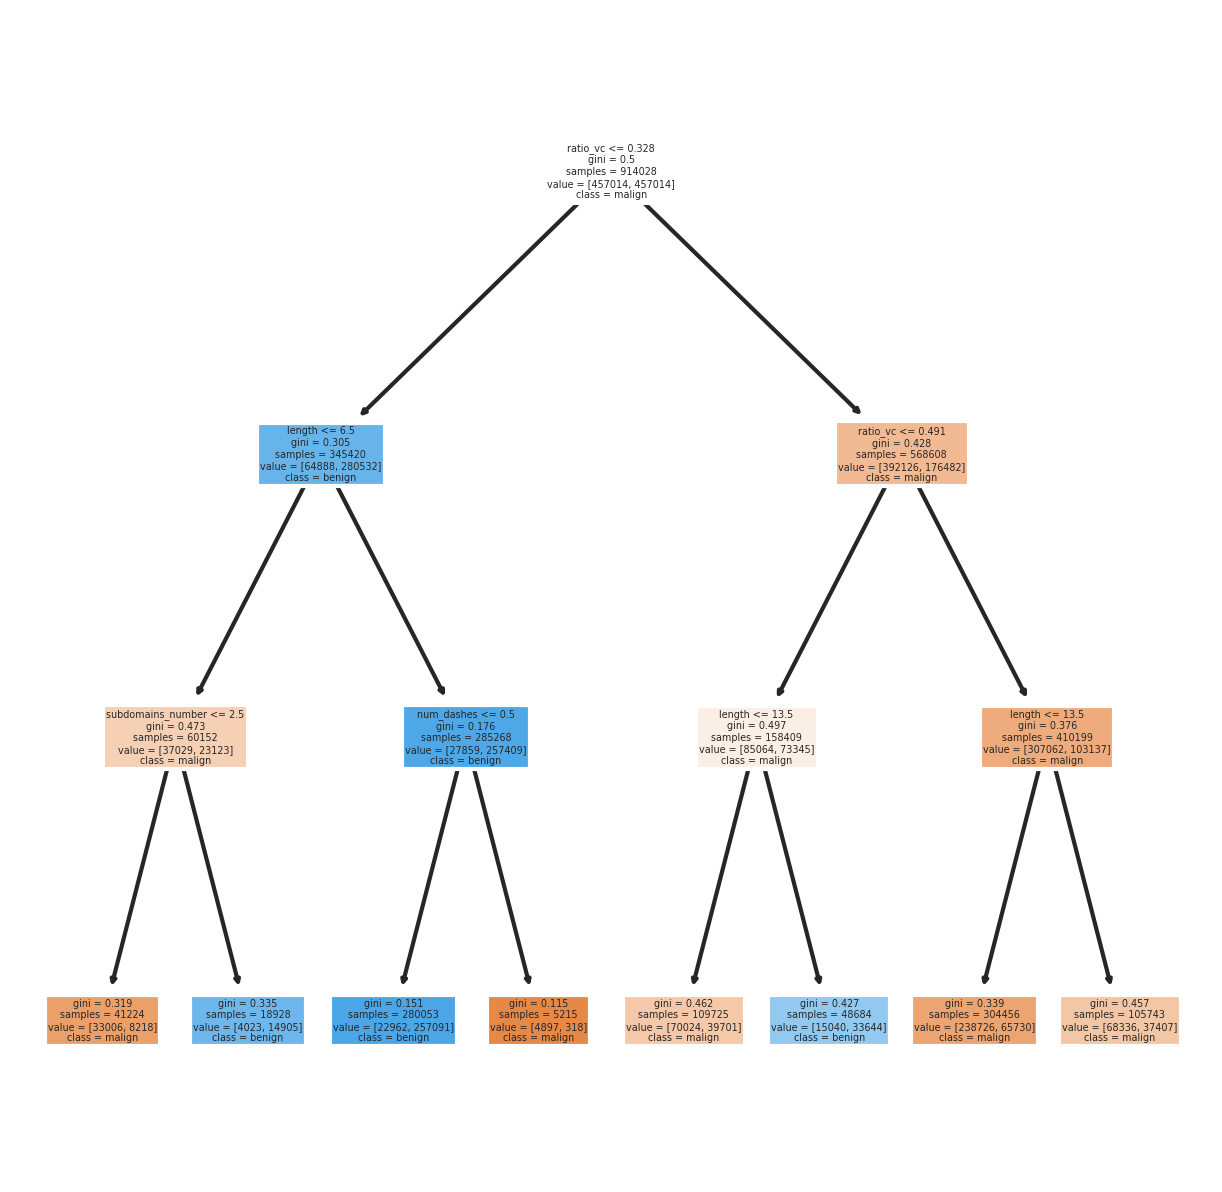

In [10]:
# Representamos el arbol
fig, axes = plt.subplots(nrows = 1,ncols = 1,figsize = (5,5), dpi=300)

tree.plot_tree(dt_cls,feature_names = X_train.columns, 
               class_names=['malign','benign'],
               filled = True,ax=axes);

In [11]:
y_test_pred = dt_cls.predict(X_test)
print("Accuracy para el conjunto de test:", sklearn.metrics.accuracy_score(y_test, y_test_pred))

Accuracy para el conjunto de test: 0.7878367496980412


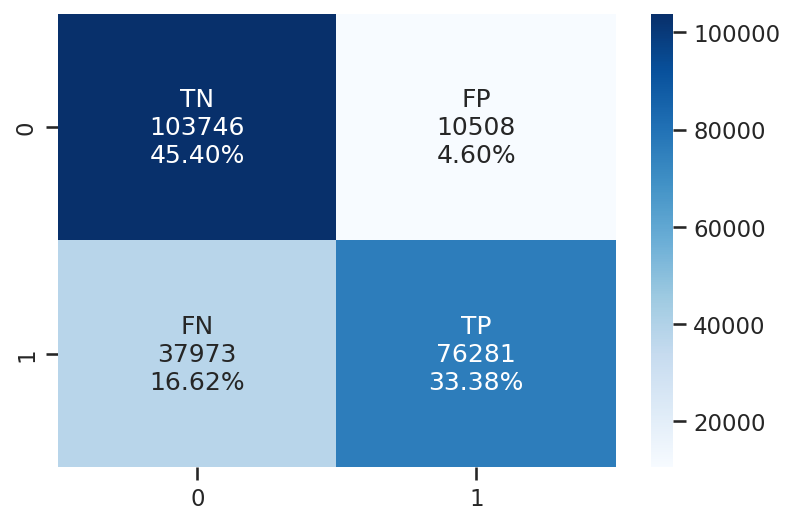

In [14]:
cf_matrix = confusion_matrix(y_test, y_test_pred)
custom_cm(cf_matrix)

In [15]:
print(classification_report(y_test, y_test_pred))

              precision    recall  f1-score   support

      benign       0.73      0.91      0.81    114254
      malign       0.88      0.67      0.76    114254

    accuracy                           0.79    228508
   macro avg       0.81      0.79      0.78    228508
weighted avg       0.81      0.79      0.78    228508



Dado que el algoritmo de clasificación `Decision Tree` facilita la interpretación visual, para entrenar el clasificador se han utilizado los datos sin estandarizar y se ha limitado la profundidad del árbol a 3 niveles.

El entrenamiento del clasificador ofrece un `accuracy`de 0,78 sobre el conjunto de test. Se puede observar que las dos variables más significativas son el `ratio_vc` y `length`, que se emplean en la clasificación en las partes superiores del árbol de decisión.

En la matriz de confusión llama la atención el porcentaje elevado de falsos negativos (16,6%) respecto a falsos positivos(4,6%).

# Random Forest

Por último, entrenaremos un clasificador $random forest$, tipo $ensemble$ basado en múltiples árboles de decisión.

Esta combinación de clasificadores realiza un muestreo tanto de elementos del dataset original de entrenamiento como de sus variables, a partir de ese muestreo aleatorio se crean múltiples árboles.

In [20]:
rf = RandomForestClassifier()
rf.fit(X_train_std, y_train_std)
y_pred_rf = rf.predict(X_test_std)

In [21]:
print("El accuracy del modelo Random Forest es:",rf.score(X_test_std, y_test_std))

El accuracy del modelo Random Forest es: 0.824461288007422


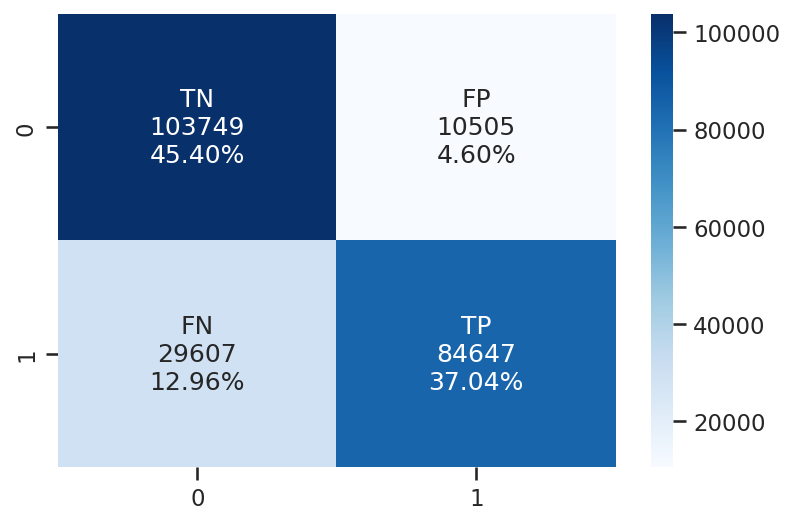

In [22]:
cf_matrix = confusion_matrix(y_test_std, y_pred_rf)
custom_cm(cf_matrix)

In [23]:
print(classification_report(y_test_std, y_pred_rf))

              precision    recall  f1-score   support

      benign       0.78      0.91      0.84    114254
      malign       0.89      0.74      0.81    114254

    accuracy                           0.82    228508
   macro avg       0.83      0.82      0.82    228508
weighted avg       0.83      0.82      0.82    228508



Como era de esperar, este clasificador obtiene los mejores resultados, con un _accuracy_ sobre el conjunto de test de 82,4%. 

En la matriz de confusión se observa que el porcentaje de falsos negativos (12,8%) es superior al de falsos positivos(4,6%)

# Conclusiones
El modelo que mejores resultados obtiene es el _Random forest_, seguido del modelo basado en árbol de decisión y por último la regresión logística.

Existen muchísimos otros modelos que se podrían haber evaluado (k-NN, Gradient boosting, ...) y también se podría haber experimentado con diversas combinaciones de hiperparámetros utilizando la función `GridSearchCV` de `sklearn`.

Asimismo también se podría haber utilizado una librería de AutoML como [`auto-sklearn`](https://github.com/automl/auto-sklearn), que combinaría los mejores clasificadores, pero se considera que los modelos evaluados son suficientes para mostrar las distintas alternativas disponibles y sus características, y a su vez reducir el consumo eléctrico requerido para el entrenamiento de estos modelos.
